In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import print_function
from __future__ import division
import pandas
import numpy as np
import matplotlib.pyplot as plt
#from ethomap.tsne import ParametricTSNE # only use with permission from Jake: use umap instead if possible
import umap

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [161]:


#Import the csv data from the file 
file_names = ['20170513_Kali-3381.csv',
              '20170514_Lio-3383.csv',
              '20170515_Elly-3383.csv',
              '20170518_Sammy-4084.csv',
              '20170519_Lissy-3381.csv',
              '20170522_Lucy-3381.csv',
              '20170523_Dudek-4084.csv',
              '20170525_Flecky-4087.csv',
              '20170530_Lasse-4087.csv',
              '201710513_Baghira-4084.csv']
df = []
df_valid_position_loc = []
df_clean = []
positions = []
for name_indx, name in enumerate(file_names):
    temp_df = pandas.read_csv('Data/' + name)
    #dealing with human walking data at the beginning
    if name_indx == 6:
        temp_df = temp_df[1666:]
    df.append(temp_df)
    df_valid_position_loc.append(
        temp_df[['location-long', 'location-lat']].notnull())
#df.describe() #this gives a summary of the dataframe columns

for df_indx in range(len(df)):
    df_clean.append(df[df_indx][df_valid_position_loc[df_indx].all(axis=1)])
    positions.append(df_clean[df_indx].as_matrix(['location-long', 'location-lat']))
print(positions[0][-1,1])


47.6782236


[ 8.8856282  8.8856839  8.885685  ...,  8.8879305  8.8880029  8.8880842]
47.6638875


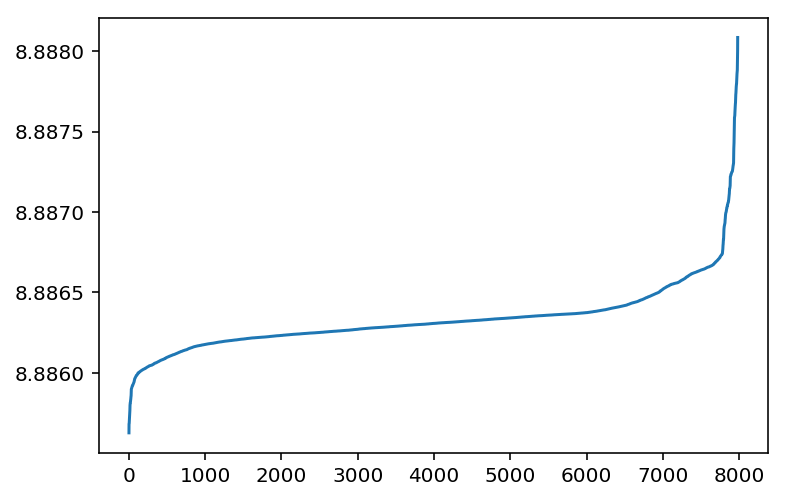

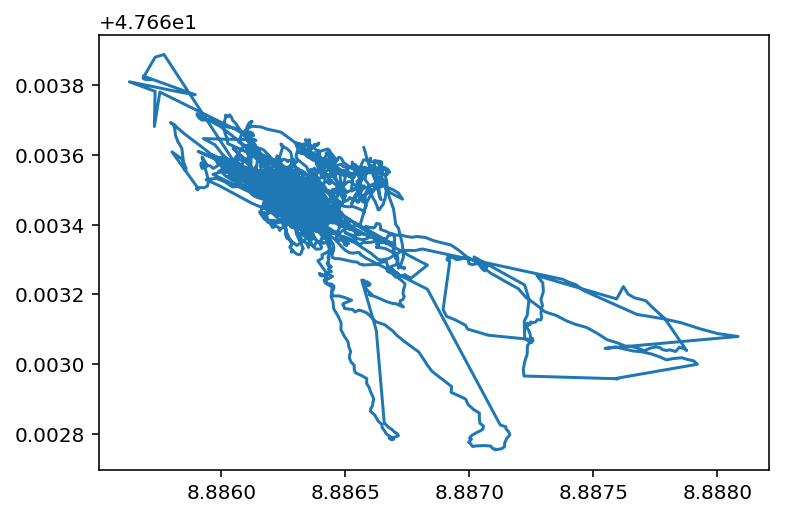

In [162]:
figure = 6
plt.plot(np.sort(positions[figure][:,0]))
plt.figure()
print(np.sort(positions[figure][:,0]))
print(positions[figure][:,1].max())
plt.plot(positions[figure][:,0], positions[figure][:,1])

In [163]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, -1)

In [165]:
length_of_segment = 21
half_of_segment = 10


def rotate_2d(matrix, angle):
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])
    rotated_matrix = np.matmul(rotation_matrix, matrix.transpose()).transpose()
    return rotated_matrix

def get_segments(loc, half_seg_length, scaling):
    num_points = 0
    for indx in range(len(loc)):
        num_points += (loc[indx].shape[0] - 2 * half_seg_length)
        
    segs = np.zeros((num_points, 2*half_seg_length+1, 2))
    counter = 0
    
    for indx, df_local in enumerate(loc):
        for seg_indx in range(df_local.shape[0] - (2 * half_seg_length)-1):
            segment = np.copy(df_local[seg_indx:(seg_indx + 2*half_seg_length + 1), :]) #Why do I need the copy?
            segment -= df_local[seg_indx + half_seg_length, :]        
            segs[counter + seg_indx, :, :] = segment 
            segs[counter + seg_indx, :, :] *= scaling
            
        counter += df_local.shape[0] - 2 * half_seg_length

    return segs

def get_vector_magnitude(segments):
    distances = np.ones((segments.shape[0], segments.shape[1]))
    for seg_indx in range(segments.shape[0]):
            distances[seg_indx] = np.sqrt(segments[seg_indx, :, 0] ** 2 +
                                               segments[seg_indx, :, 1] ** 2)
    return(distances)

def get_vector_from_last(segments):
    distances = np.zeros_like(segments)
    for indx in range(0, segments.shape[1]-1):
        distances[:, indx] = segments[:, indx + 1,:] - segments[:, indx,:]
    return distances

def get_mean_distance_from_local_origin(segments):
    distances = get_vector_magnitude(segments)
    distances = np.sum(distances, 1)
    distances /= segments.shape[1]
    return(distances)

def get_mean_step_displacement(segments):
    mean_displacement = np.zeros(segments.shape[0])
    displacement = get_vector_from_last(segments)
    displacement = get_vector_magnitude(displacement)
    mean_displacement = np.sum(displacement, 1)
    mean_displacement /= segments.shape[1]
    return mean_displacement

def get_mean_net_displacement(segments):
    distances = np.zeros(segments.shape[0])
    difference_vector = segments[:, -1] - segments[:, 0]
    distances = np.sqrt(difference_vector[:,0] ** 2 + difference_vector[:,1] ** 2)
    distances /= segments.shape[1]
    return(distances)


    
            
            

path_segments = get_segments(positions, half_of_segment, 10000.0)

print('path_segments.shape: ', path_segments.shape)
print('min: ', path_segments.min(), '\n', 'max: ', path_segments.max())

mean_net_displacement = get_mean_net_displacement(path_segments)
mean_step_displacement = get_mean_step_displacement(path_segments)
mean_distance_from_local_origin = get_mean_distance_from_local_origin(path_segments)

tsne_input = np.column_stack((mean_net_displacement, mean_step_displacement, mean_distance_from_local_origin))

print('tsne_input: ', tsne_input.shape)
print('min: ', tsne_input[:,0].min(), '\n', 'max: ', tsne_input[:,0].max())
print('min: ', tsne_input[:,1].min(), '\n', 'max: ', tsne_input[:,1].max())
print('min: ', tsne_input[:,2].min(), '\n', 'max: ', tsne_input[:,2].max())


path_segments.shape:  (149935, 21, 2)
min:  -12.741 
 max:  12.741
tsne_input:  (149935, 3)
min:  0.0 
 max:  0.709500980777
min:  0.0 
 max:  1.20673250555
min:  0.0 
 max:  6.13914824701


mean_net_displacement


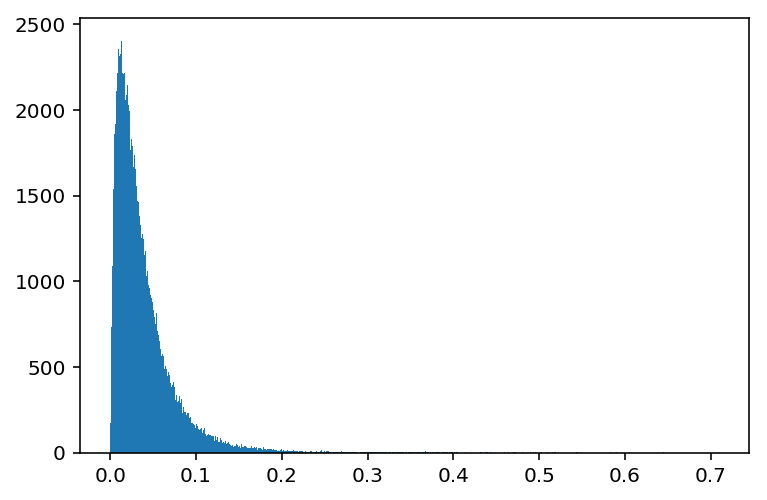

mean_step_displacement


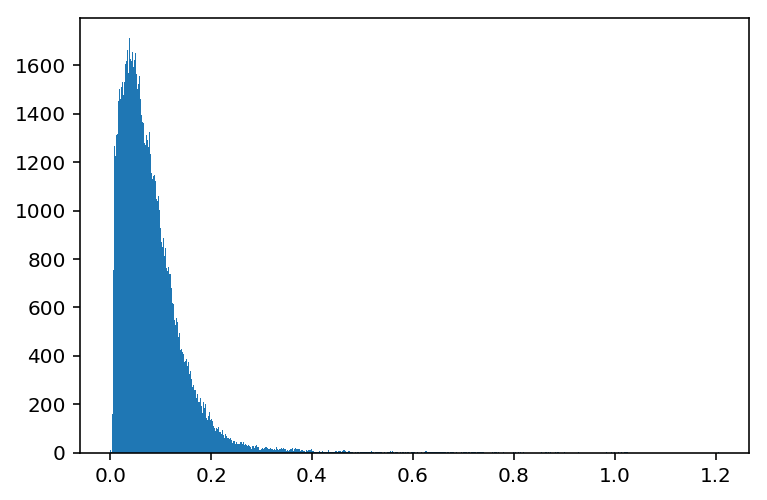

mean_distance_from_local_origin


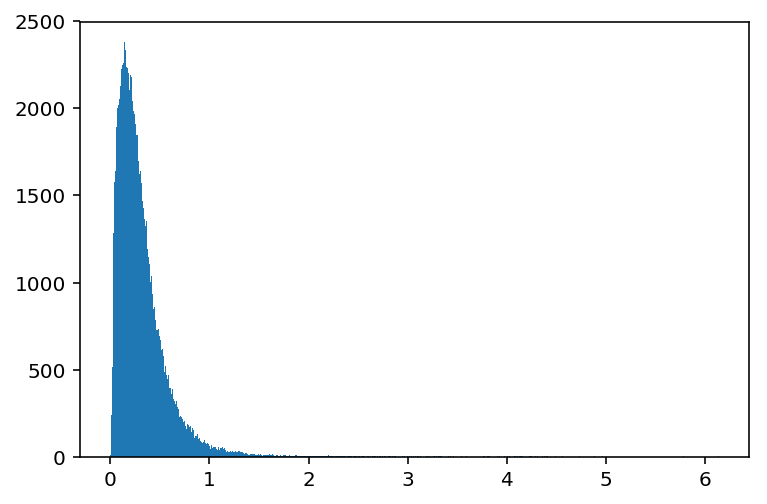

In [169]:
#check distributions of the tSNE input parameters
min_range = 15
max_range = -15
num_bins = 1000
print('mean_net_displacement')
plt.figure()
plt.hist(mean_net_displacement[min_range:max_range], num_bins)
plt.show()
print('mean_step_displacement')
plt.figure()
plt.hist(np.sort(mean_step_displacement[min_range:max_range]), num_bins)
plt.show()
print('mean_distance_from_local_origin')
plt.figure()
plt.hist(np.sort(mean_distance_from_local_origin[min_range:max_range]), num_bins)
plt.show()

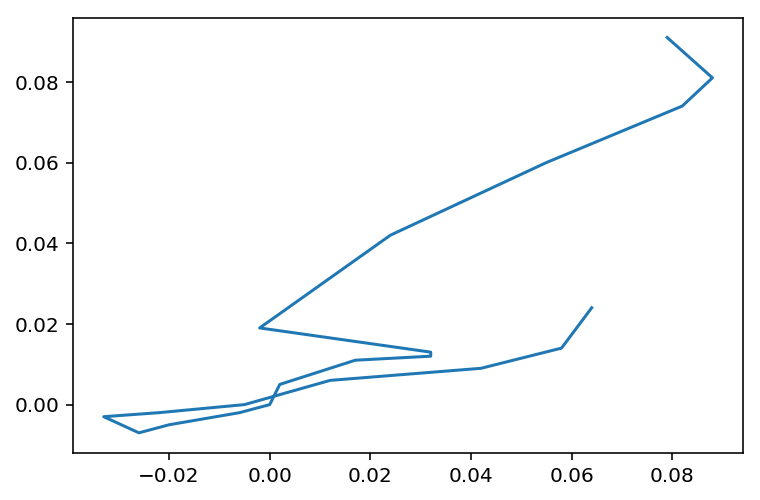

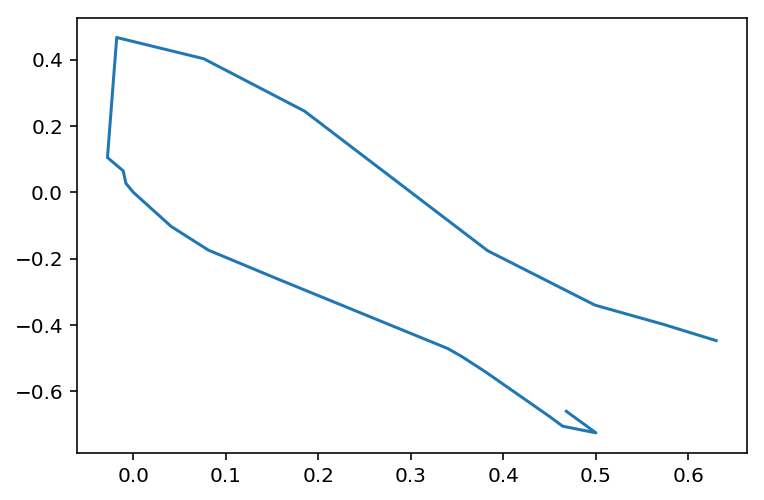

In [174]:
#View some demo segments
sampling = 1000
for plt_indx in range(2):
    plt.figure()
    plt.plot(path_segments[plt_indx * sampling,:,0], path_segments[plt_indx * sampling,:,1])

In [6]:
# #Train the ptSNE embedding
# tsne_distance = ParametricTSNE(n_jobs=-1, metric='cosine', verbose=1)
# #use every other point for training
# tsne_input_sample = tsne_input[::2] 
# print('using ' , len(tsne_input_sample), ' points for training.')
# tsne_distance.fit(tsne_input_sample)

#UMAP
#use every point for training 
#use fewer for faster training
umap_input_sample = tsne_input[::1]
print('using ' , len(umap_input_sample), ' points for training.')
embedding = umap.UMAP(metric='cosine').fit_transform(umap_input_sample)

74968
Precomputing P-values...


/usr/local/lib/python2.7/dist-packages/ethomap/tsne.py:573: UserWarning: n_samples does not divide by batch_size evenly (n_samples % batch_size != 0). 4968 samples will be discarded.
  warn("n_samples does not divide by batch_size evenly (n_samples % batch_size != 0). {} samples will be discarded.".format(batch_shape_mod))


Computing P-values for batch 3 of 14
Computing P-values for batch 2 of 14
Computing P-values for batch 1 of 14
Computing P-values for batch 7 of 14
Computing P-values for batch 8 of 14
Computing P-values for batch 4 of 14
Computing P-values for batch 5 of 14
Computing P-values for batch 6 of 14
Computing P-values for batch 9 of 14
Computing P-values for batch 10 of 14
Computing P-values for batch 11 of 14
Computing P-values for batch 12 of 14
Computing P-values for batch 13 of 14
Computing P-values for batch 14 of 14
Epoch 1/100
70000/70000 [==============================] - 2s - loss: 5.3996     
Epoch 2/100
70000/70000 [==============================] - 1s - loss: 5.0127     
Epoch 3/100
70000/70000 [==============================] - 2s - loss: 4.5038     
Epoch 4/100
70000/70000 [==============================] - 1s - loss: 4.1463     
Epoch 5/100
70000/70000 [==============================] - 1s - loss: 3.7813     
Epoch 6/100
70000/70000 [==============================] - 1s - los

<ethomap.tsne.ParametricTSNE instance at 0x7fbfd0964488>

In [7]:
##Embed all the points in tSNE space
##not sure what this is for umap
#result = tsne_distance.transform(tsne_input)
result = embedding

In [8]:
#create dataframe
#Check they are the same size
print(len(tsne_input))
print(len(result))

names = []
#Don't include the points at the beginning and end that didn't have enough padding to be classified
pos = positions[0][half_of_segment:-half_of_segment]
for indx in range(1, len(positions)):
    pos = np.vstack((pos, positions[indx][half_of_segment:-half_of_segment]))

#Prepare a name column for the data frame
for indx in range(0, len(positions)):
    for __ in range(len(positions[indx][half_of_segment:-half_of_segment])):
        names.append(file_names[indx])
        
names = np.asarray(names)
names = np.expand_dims(names, 1)
print(names.shape)
data = np.hstack((names,pos, tsne_input, result)) 

df_out = pandas.DataFrame(data, columns=['file',
                                         'long', 
                                         'lat', 
                                         'mean_net_displacement', 
                                         'mean_step_displacement', 
                                         'mean_distance_from_local_origin', 
                                         'tsne_dim1', 
                                         'tsne_dim2'
                                        ])

149935
149935
(149935, 1)


In [9]:
df_out

,file,long,lat,mean_net_displacement,mean_step_displacement,mean_distance_from_local_origin,tsne_dim1,tsne_dim2
0,20170513_Kali-3381.csv,9.1659219,47.6786169,0.00326945598311,0.0159781157737,0.0424888963452,15.4353790283,-19.565164566
1,20170513_Kali-3381.csv,9.1659221,47.6786174,0.00458034843987,0.0165755221093,0.0436619956382,9.09178733826,-21.9571685791
2,20170513_Kali-3381.csv,9.1659236,47.678618,0.00486553896431,0.0165406728214,0.045229699694,8.77260017395,-20.3084278107
3,20170513_Kali-3381.csv,9.1659251,47.6786181,0.00501064625903,0.0160585469903,0.0524004122669,14.1254463196,-10.2185277939
4,20170513_Kali-3381.csv,9.1659251,47.6786182,0.0056407972904,0.0157151611536,0.0561170959136,13.4498996735,-5.56158876419
5,20170513_Kali-3381.csv,9.1659217,47.6786188,0.00573844101125,0.0159487550948,0.0576419551235,13.723077774,-4.86156225204
6,20170513_Kali-3381.csv,9.1659243,47.6786211,0.0060702613219,0.0163869977489,0.057046380402,11.7074775696,-7.06163597107
7,20170513_Kali-3381.csv,9.1659274,47.6786229,0.00690476190718,0.0171791844313,0.0649156305834,11.9147520065,-2.54613161087
8,20170513_Kali-3381.csv,9.1659301,47.6786243,0.00750041571203,0.0175412717128,0.079347974139,15.3962640762,10.1247205734
9,20170513_Kali-3381.csv,9.1659307,47.678625,0.00801925121247,0.0173723435471,0.0850380411734,15.390001297,14.8606948853


In [10]:
df_out.to_csv('behavioral_quantization_3.csv')

In [3]:
import ethomap
import pickle

In [4]:
imported_df = pandas.read_csv('behavioral_quantization_3.csv')
imported_df.describe()


,Unnamed: 0,long,lat,mean_net_displacement,mean_step_displacement,mean_distance_from_local_origin,tsne_dim1,tsne_dim2
count,149935.000000,149935.000000,149935.000000,149935.000000,149935.000000,149935.000000,149935.000000,149935.000000
mean,74967.000000,9.099865,47.709229,0.038390,0.080587,0.314992,3.830999,-0.254938
std,43282.650643,0.095806,0.031410,0.037321,0.066097,0.275728,13.199394,16.032036
min,0.000000,8.885628,47.662754,0.000000,0.000000,0.000000,-22.974134,-32.704372
25%,37483.500000,9.009250,47.686207,0.014698,0.036950,0.142137,-6.380468,-12.581385
50%,74967.000000,9.148608,47.691689,0.028007,0.066153,0.249028,4.100339,-0.324890
75%,112450.500000,9.176171,47.744450,0.049563,0.106356,0.403376,13.994175,12.162572
max,149934.000000,9.202269,47.767844,0.709501,1.206733,6.139148,31.830545,31.936628


In [5]:
tsne = imported_df.as_matrix(['tsne_dim1', 'tsne_dim2'])
tsne

array([[ 15.43537903, -19.56516457],
       [  9.09178734, -21.95716858],
       [  8.77260017, -20.30842781],
       ..., 
       [  7.42836714,  14.32450962],
       [ -1.08044887,   9.21901321],
       [  4.37697506,  -3.74404621]])

In [6]:
size_of_behavior_space = 100
Y, density = ethomap.mapping.point_density(tsne, 1.0, size_of_behavior_space)
#density = np.where(density>.00000000000001, density, np.zeros_like(density))

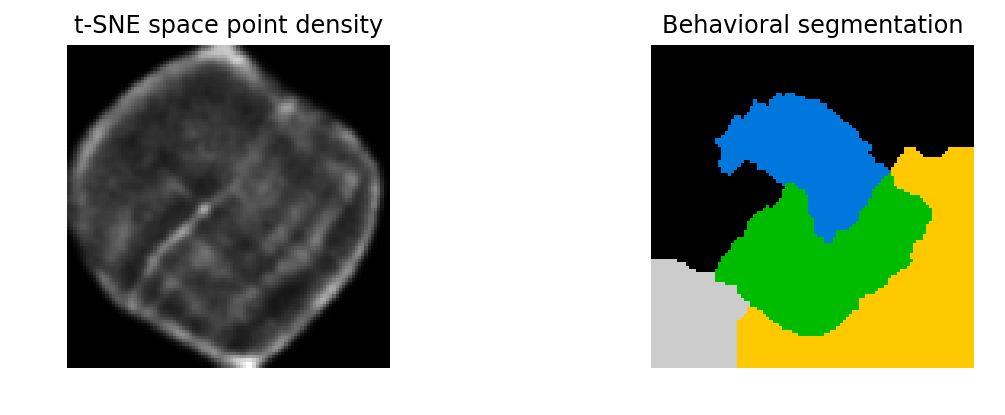

There are  5  behavioral types.


In [7]:
# Generate the markers as local maxima of the distance to the background
colormap = plt.cm.spectral 

local_maxi = peak_local_max(density, indices=False, min_distance = 13)
markers = ndi.label(local_maxi)[0]
labels = watershed(-density, markers, mask=density)
number_of_states = labels.max()

fig, axes = plt.subplots(ncols=2, figsize=(9, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(density, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('t-SNE space point density')
ax[1].imshow(labels, cmap=colormap, interpolation='nearest')
ax[1].set_title('Behavioral segmentation')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

print('There are ', number_of_states, ' behavioral types.')

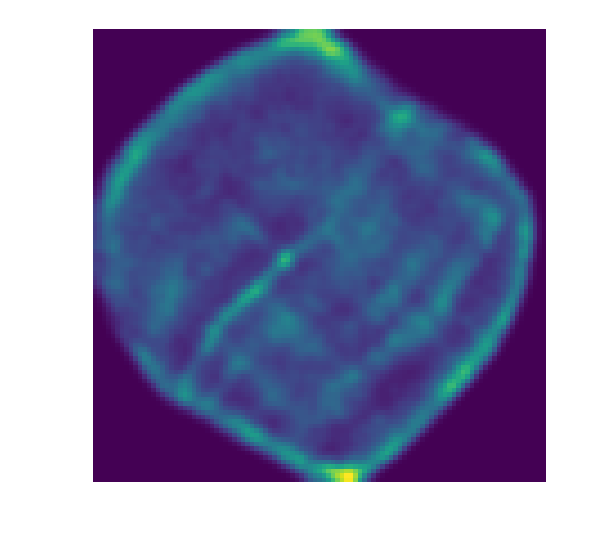

In [8]:
plt.figure(figsize=(3, 3), dpi=100)
plt.imshow((density), cmap='viridis')
plt.axis('off')
plt.show()

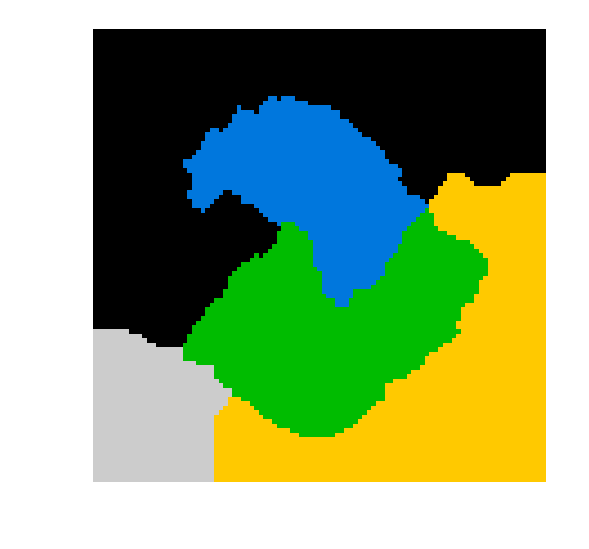

In [9]:
plt.figure(figsize=(3, 3), dpi=100)
plt.imshow(labels, cmap=colormap, interpolation='nearest')
plt.axis('off')
plt.show()

In [13]:
#Calculate each segments segmentation label
segment_start = 0
segment_end = None
tsne_d1 = np.squeeze(np.asmatrix(imported_df['tsne_dim1'][segment_start:segment_end]))
tsne_d2 = np.squeeze(np.asmatrix(imported_df['tsne_dim2'][segment_start:segment_end]))
tsne_d1_scaled = size_of_behavior_space * (tsne_d1 - tsne_d1.min()) / (tsne_d1.max() - tsne_d1.min())
tsne_d2_scaled = size_of_behavior_space * (tsne_d2 - tsne_d2.min()) / (tsne_d2.max() - tsne_d2.min())
tsne_d1_scaled = tsne_d1_scaled.astype(int)
tsne_d2_scaled = tsne_d2_scaled.astype(int)
color = labels[tsne_d1_scaled, tsne_d2_scaled] 

imported_df['behavioral_label'] = color[0]
#imported_df = imported_df.drop('Unnamed: 0', axis=1)

#save dataframe to .csv
imported_df.to_csv('cats_labeled_behavioral_quantization.csv')


In [151]:
imported_df

,file,long,lat,mean_net_displacement,mean_step_displacement,mean_distance_from_local_origin,tsne_dim1,tsne_dim2,behavioral_label
0,20170513_Kali-3381.csv,9.165922,47.678617,0.003269,0.015978,0.042489,15.435379,-19.565165,3
1,20170513_Kali-3381.csv,9.165922,47.678617,0.004580,0.016576,0.043662,9.091787,-21.957169,1
2,20170513_Kali-3381.csv,9.165924,47.678618,0.004866,0.016541,0.045230,8.772600,-20.308428,1
3,20170513_Kali-3381.csv,9.165925,47.678618,0.005011,0.016059,0.052400,14.125446,-10.218528,3
4,20170513_Kali-3381.csv,9.165925,47.678618,0.005641,0.015715,0.056117,13.449900,-5.561589,3
5,20170513_Kali-3381.csv,9.165922,47.678619,0.005738,0.015949,0.057642,13.723078,-4.861562,3
6,20170513_Kali-3381.csv,9.165924,47.678621,0.006070,0.016387,0.057046,11.707478,-7.061636,3
7,20170513_Kali-3381.csv,9.165927,47.678623,0.006905,0.017179,0.064916,11.914752,-2.546132,3
8,20170513_Kali-3381.csv,9.165930,47.678624,0.007500,0.017541,0.079348,15.396264,10.124721,3
9,20170513_Kali-3381.csv,9.165931,47.678625,0.008019,0.017372,0.085038,15.390001,14.860695,3


(47.662754100000001, 47.767843599999999)

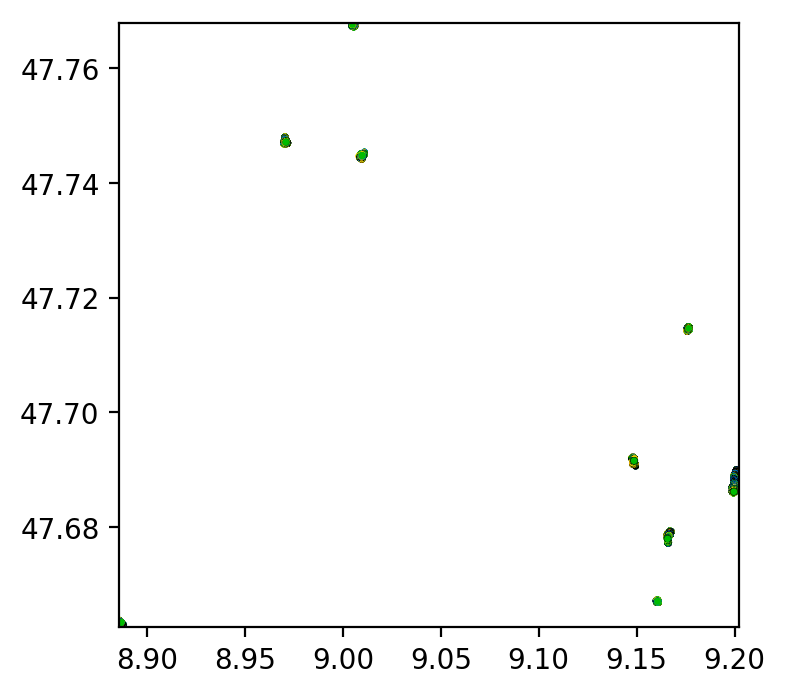

In [14]:
#plot all of the trajectories
x = imported_df['long'][segment_start:segment_end]
y = imported_df['lat'][segment_start:segment_end] 
fig = plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(x, y, s = 2, c = imported_df['behavioral_label'], cmap=colormap)
plt.xlim(imported_df['long'][segment_start:segment_end].min(), imported_df['long'][segment_start:segment_end].max())
plt.ylim(imported_df['lat'][segment_start:segment_end].min(), imported_df['lat'][segment_start:segment_end].max())



In [15]:
country_cats = [
              '20170515_Elly-3383.csv',
              '20170518_Sammy-4084.csv',
              '20170519_Lissy-3381.csv',
              '20170522_Lucy-3381.csv',
              '20170523_Dudek-4084.csv',
              '20170530_Lasse-4087.csv',]

city_cats = ['20170513_Kali-3381.csv',
              '20170514_Lio-3383.csv',
              '20170525_Flecky-4087.csv',
              '201710513_Baghira-4084.csv']

all_cats = country_cats + city_cats

city_df = imported_df[imported_df['file'].isin(city_cats)]
country_df = imported_df[imported_df['file'].isin(country_cats)]

In [16]:
environment =  all_cats
environment_df = imported_df[imported_df['file'].isin(environment)]

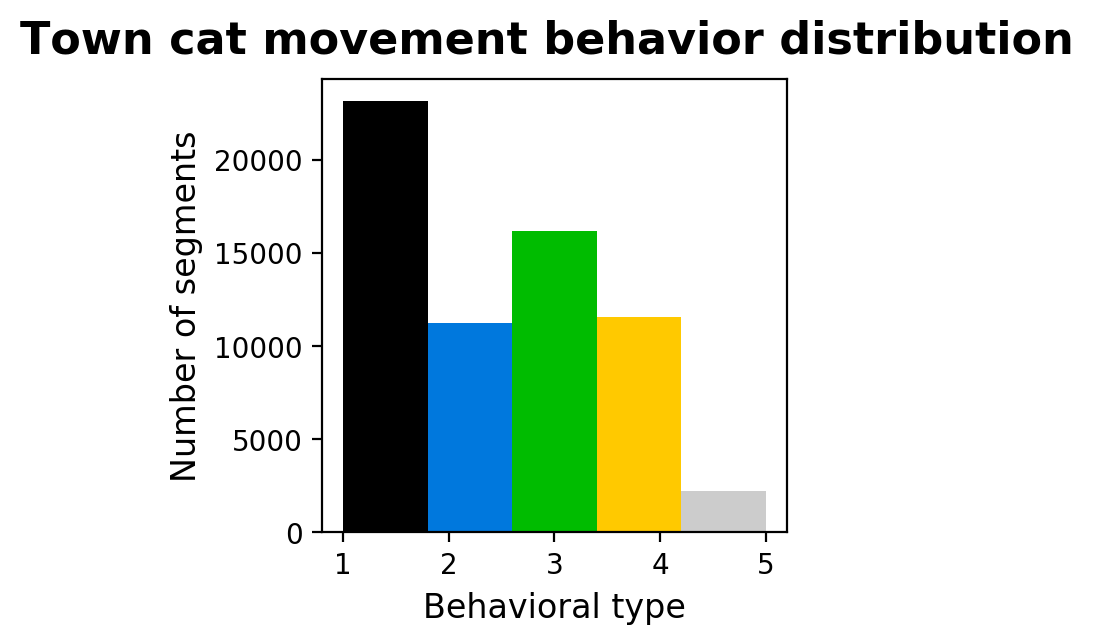

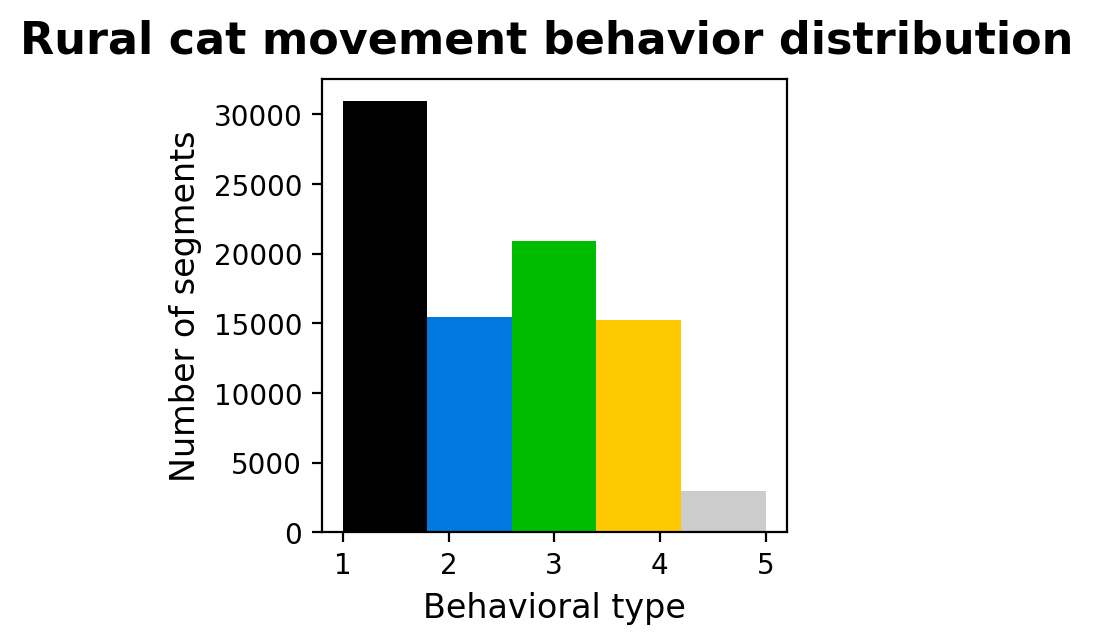

In [17]:
plt.figure()
fig = plt.figure(figsize=(3, 3), dpi=100)
fig.suptitle('Town cat movement behavior distribution', fontsize=16, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Behavioral type', fontsize=12)
ax.set_ylabel('Number of segments', fontsize=12)
n, bins, patches = plt.hist(city_df['behavioral_label'], bins=number_of_states)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = colormap
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.show()

fig = plt.figure(figsize=(3, 3), dpi=100)
fig.suptitle('Rural cat movement behavior distribution', fontsize=16, fontweight='bold')
ax = fig.add_subplot(111)
ax.set_xlabel('Behavioral type', fontsize=12)
ax.set_ylabel('Number of segments', fontsize=12)

n, bins, patches = plt.hist(country_df['behavioral_label'], bins=number_of_states)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
cm = colormap

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

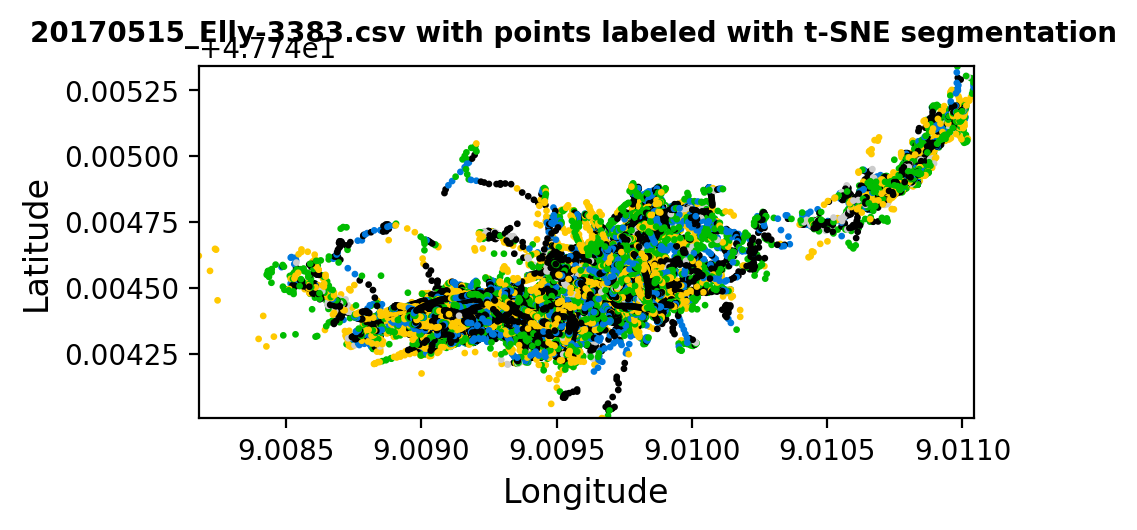

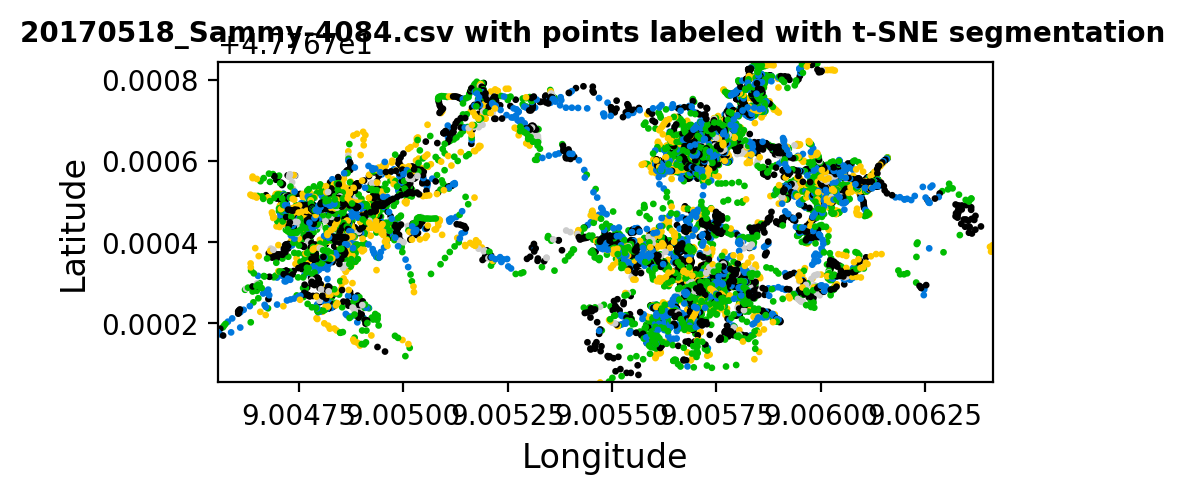

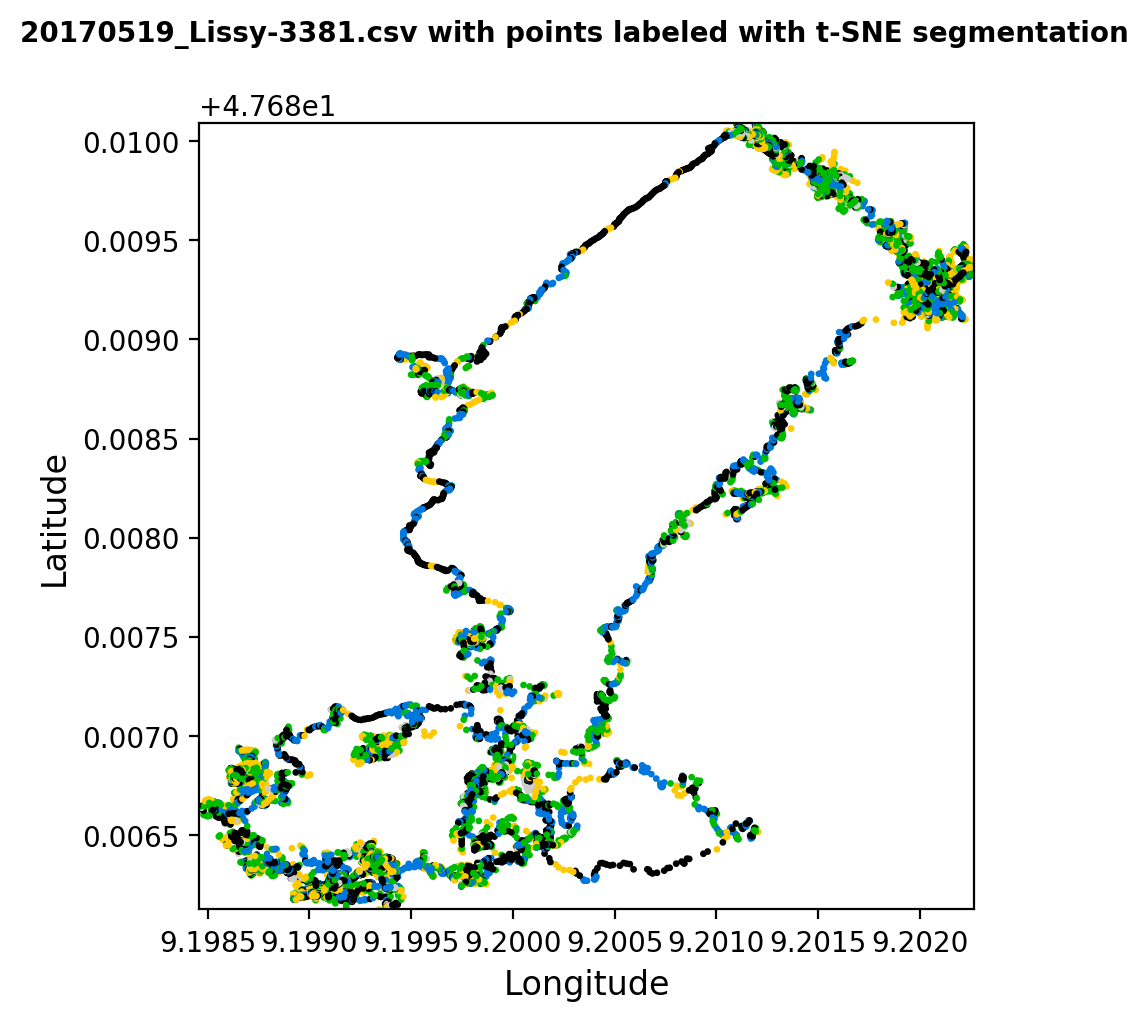

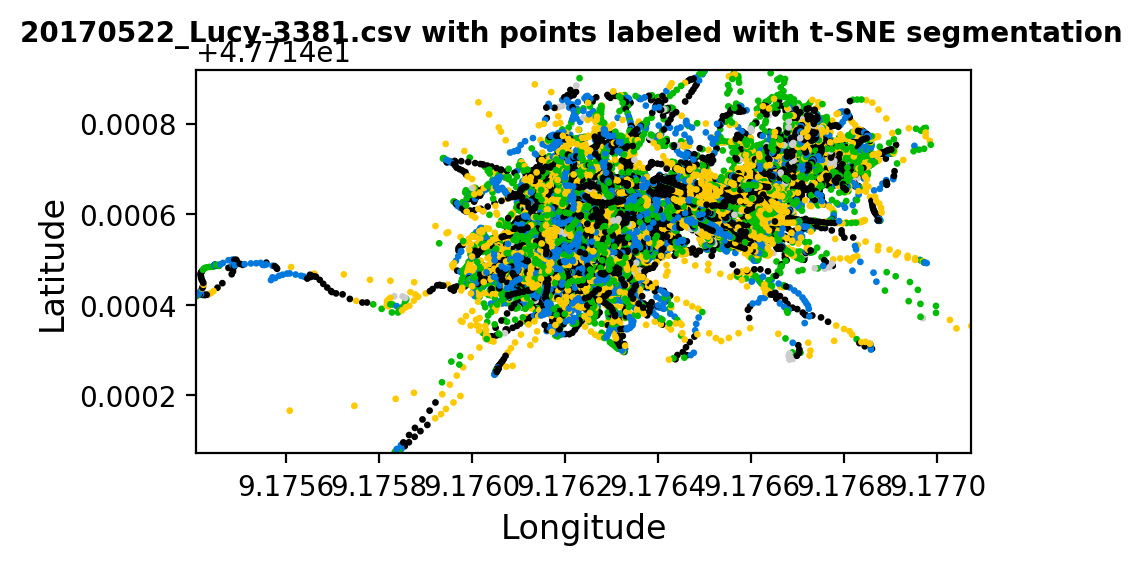

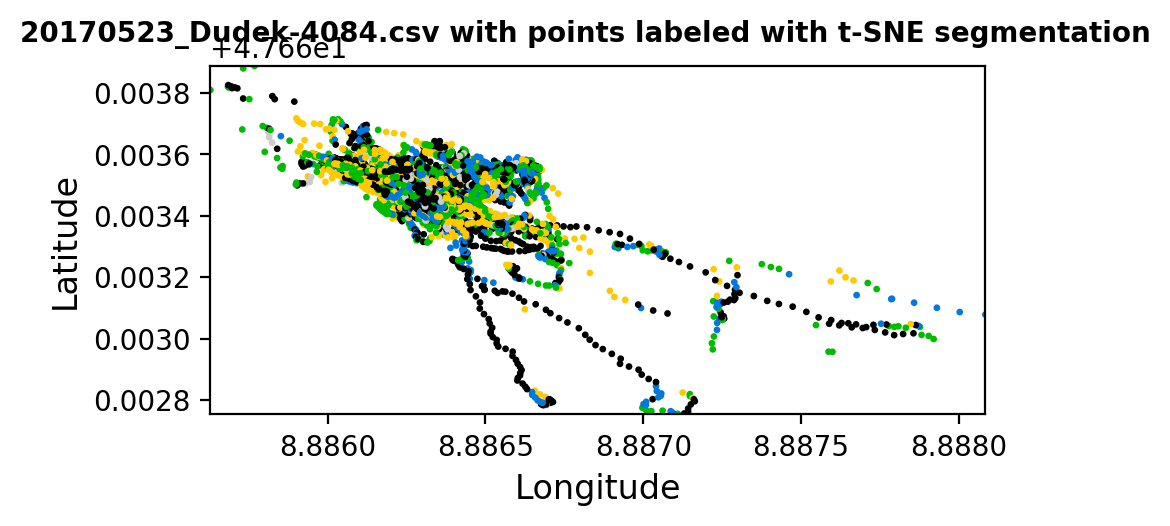

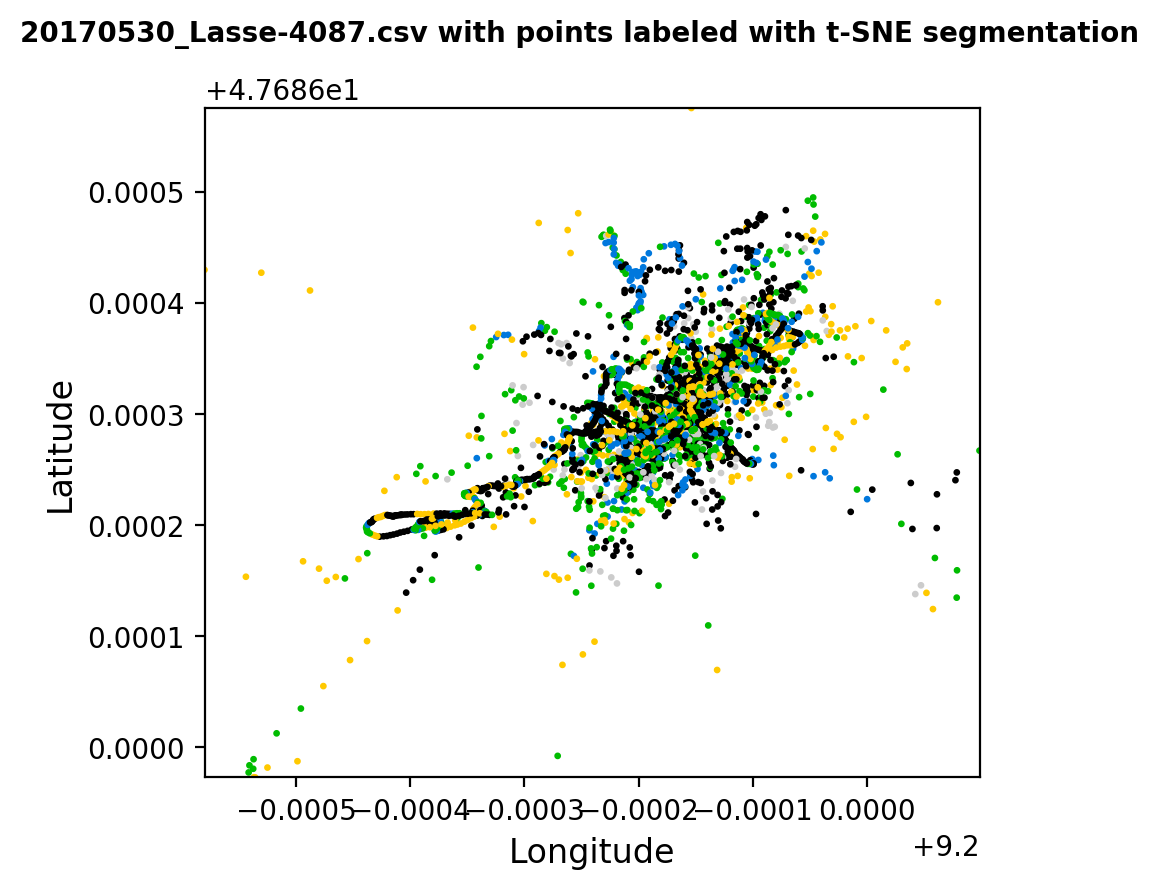

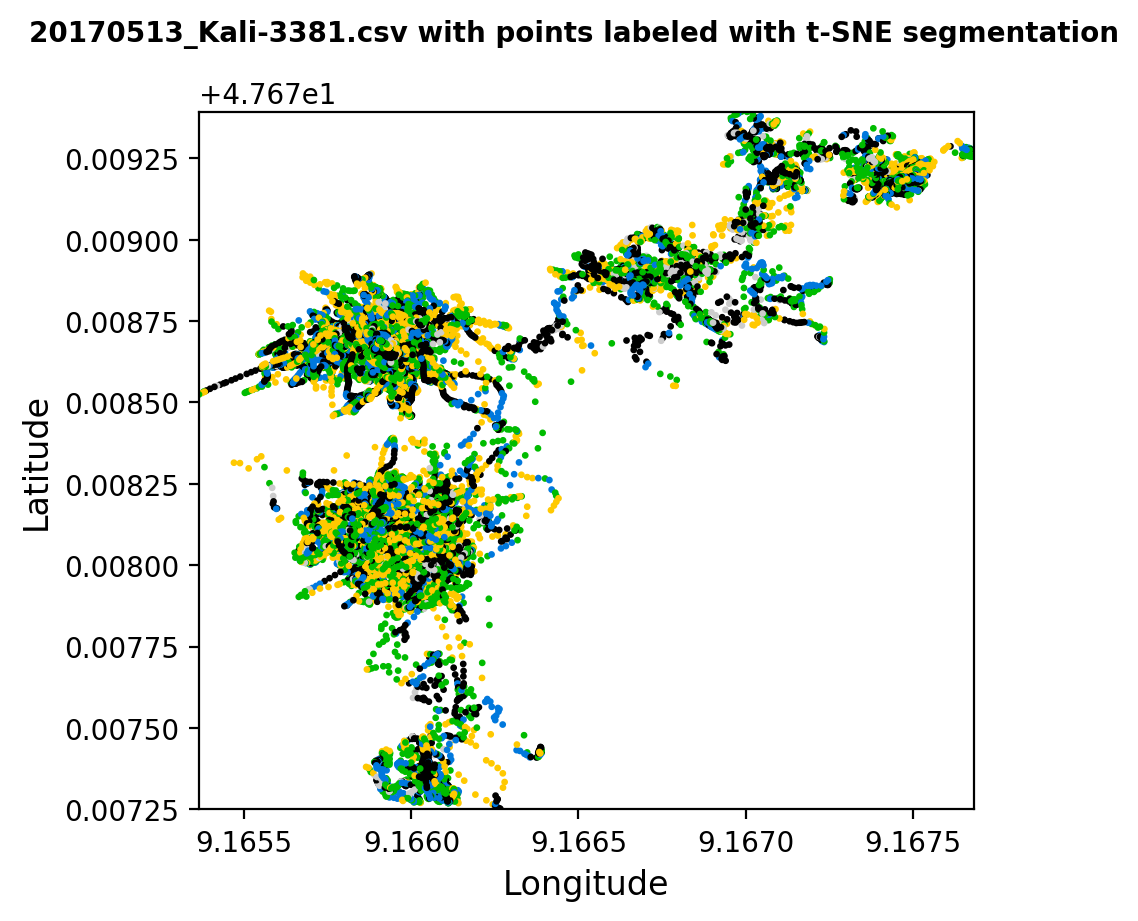

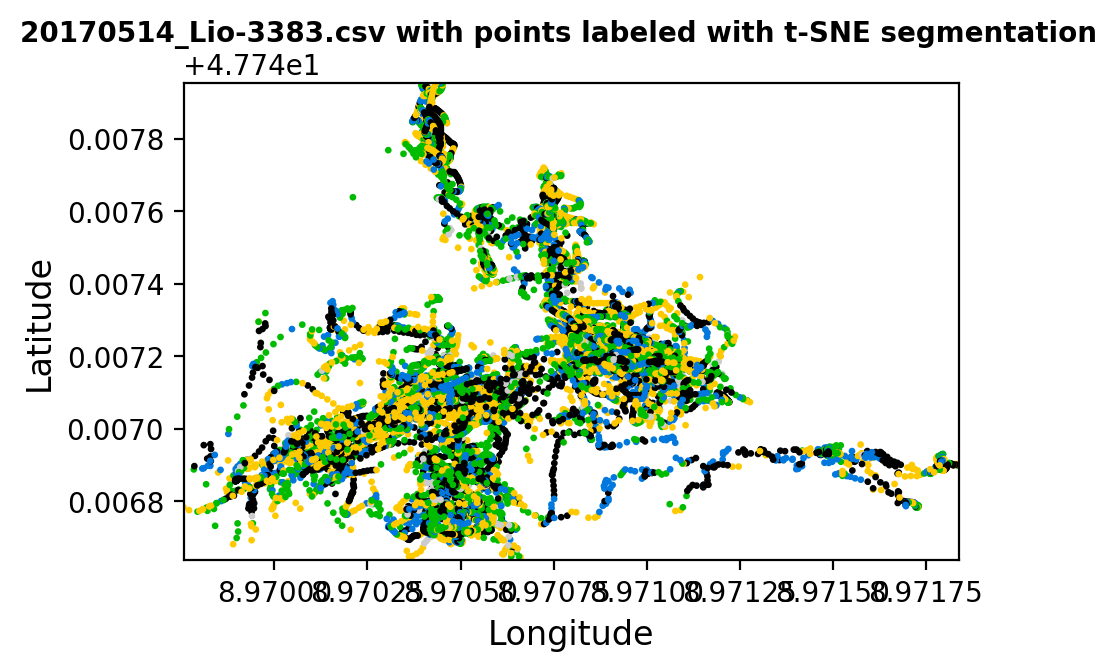

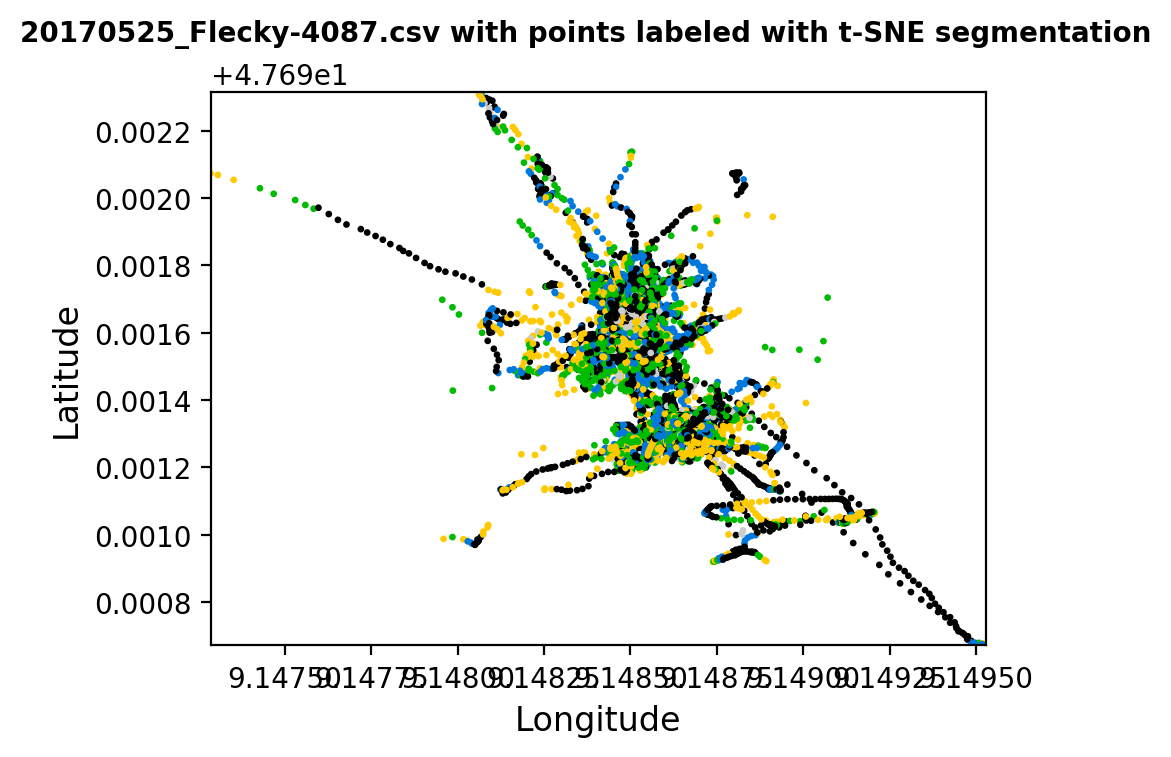

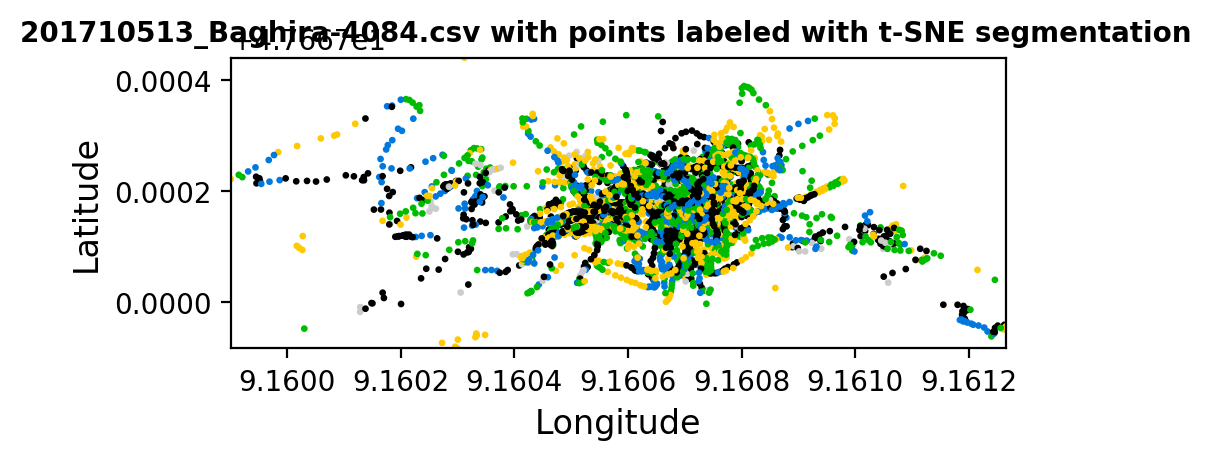

In [18]:
size_graph = 5
for cat_indx in range(len(environment)):
    single_cat = environment_df[environment_df['file'] == environment[cat_indx]] 
    scale_long = single_cat['long'][segment_start:segment_end].max() - single_cat['long'][segment_start:segment_end].min() 
    scale_lat = single_cat['lat'][segment_start:segment_end].max() - single_cat['lat'][segment_start:segment_end].min()
    scale = scale_lat / scale_long 
    fig = plt.figure(figsize=(size_graph, size_graph * scale), dpi=100)
    fig.suptitle((np.asmatrix(single_cat['file'])[0,0] + ' with points labeled with t-SNE segmentation'),
                 fontsize=10, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    plt.scatter(single_cat['long'], single_cat['lat'], c=single_cat['behavioral_label'], s=2.0, cmap=colormap)
    plt.xlim(single_cat['long'][segment_start:segment_end].min(), single_cat['long'][segment_start:segment_end].max())
    plt.ylim(single_cat['lat'][segment_start:segment_end].min(), single_cat['lat'][segment_start:segment_end].max())
    fig = plt.figure()
    plt.show()



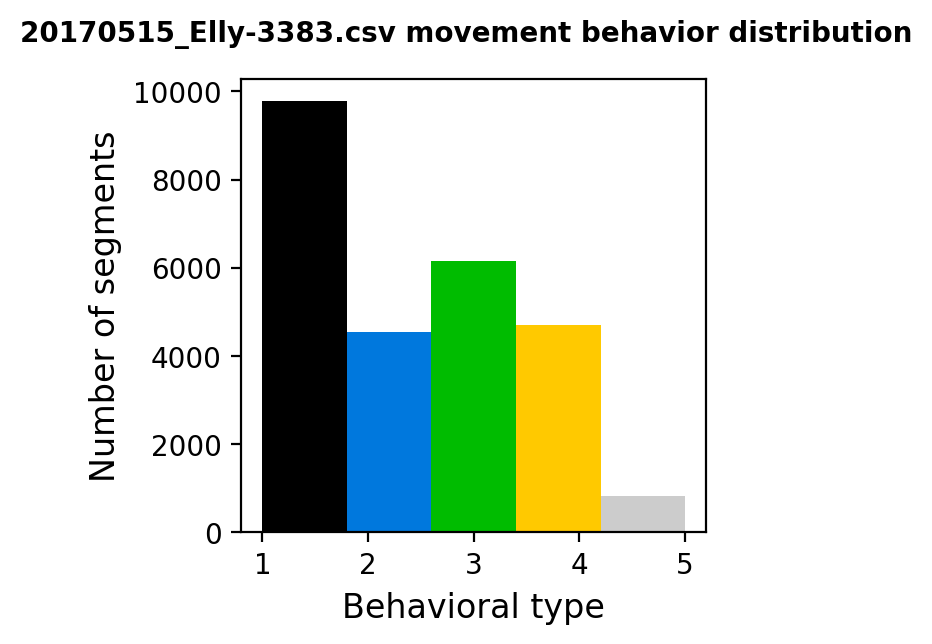

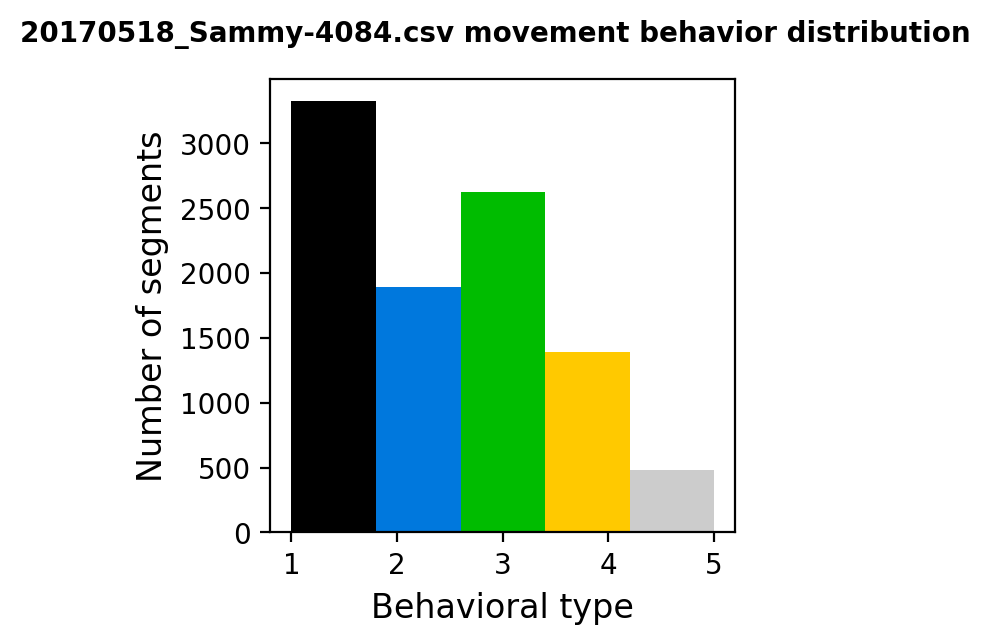

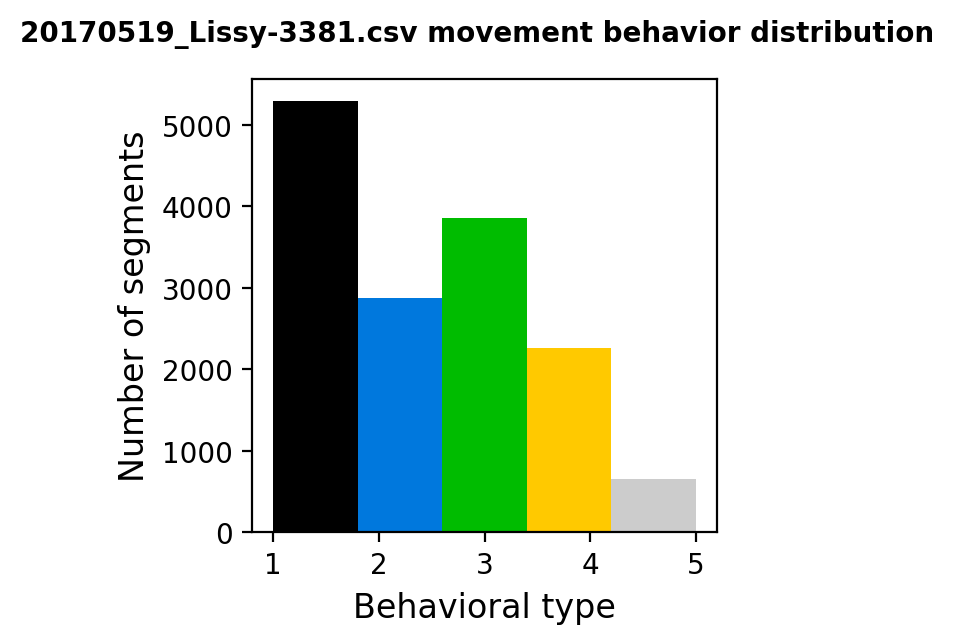

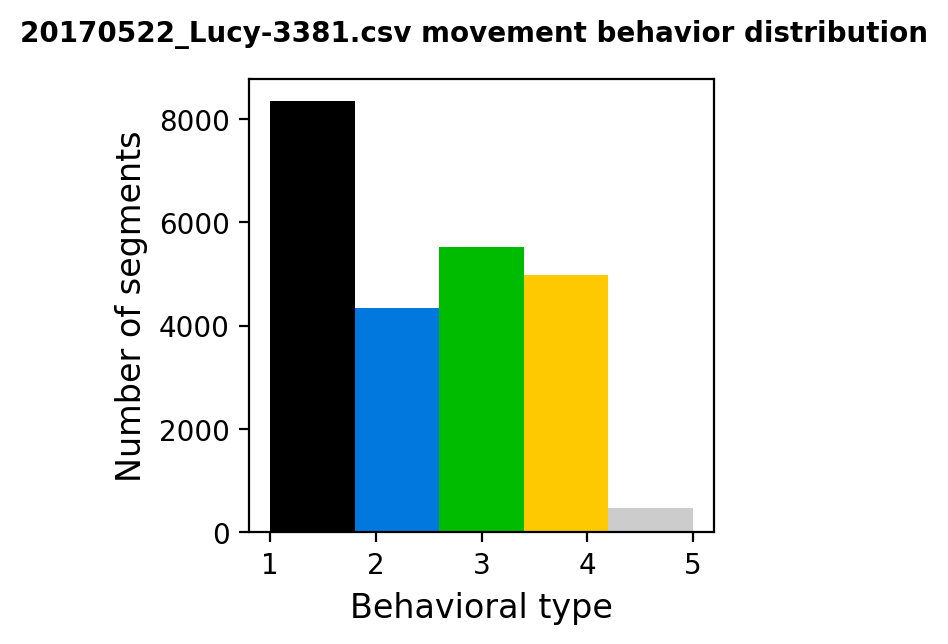

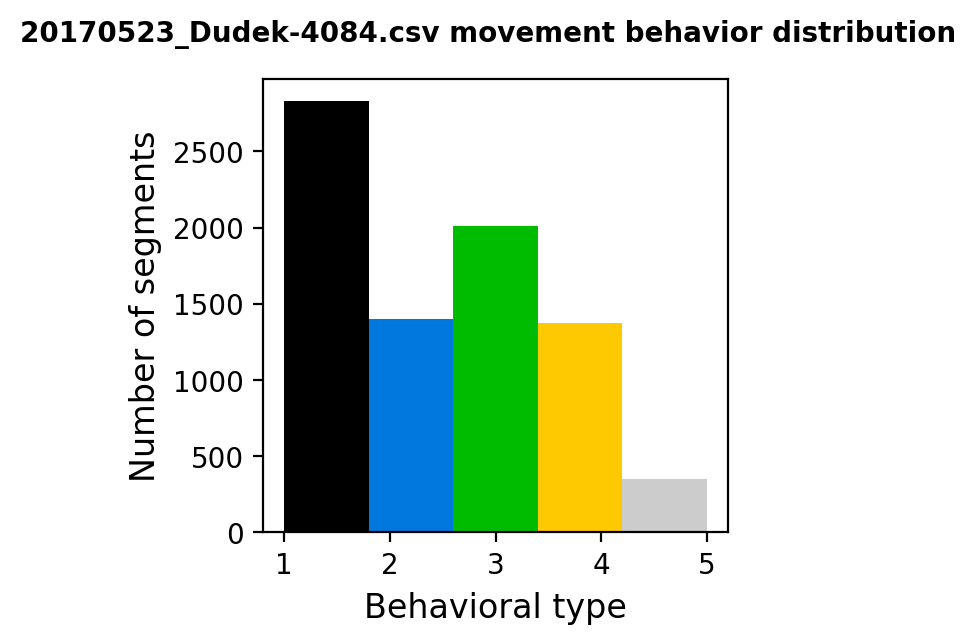

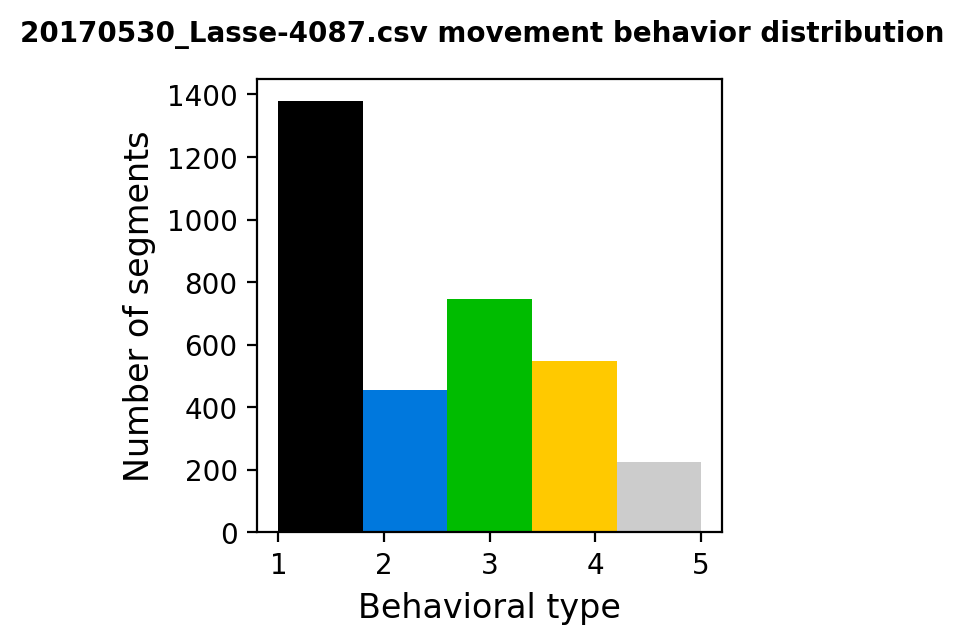

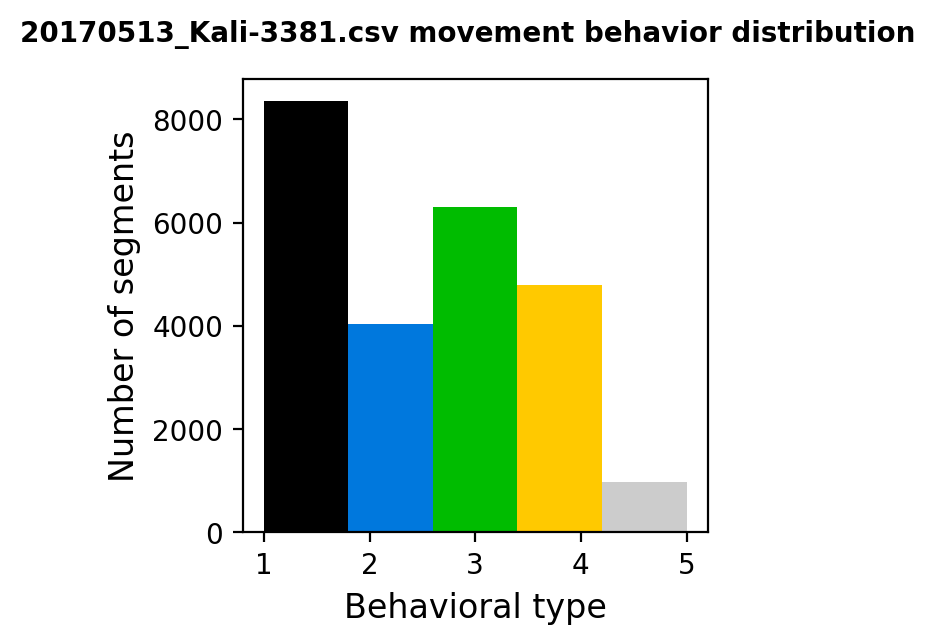

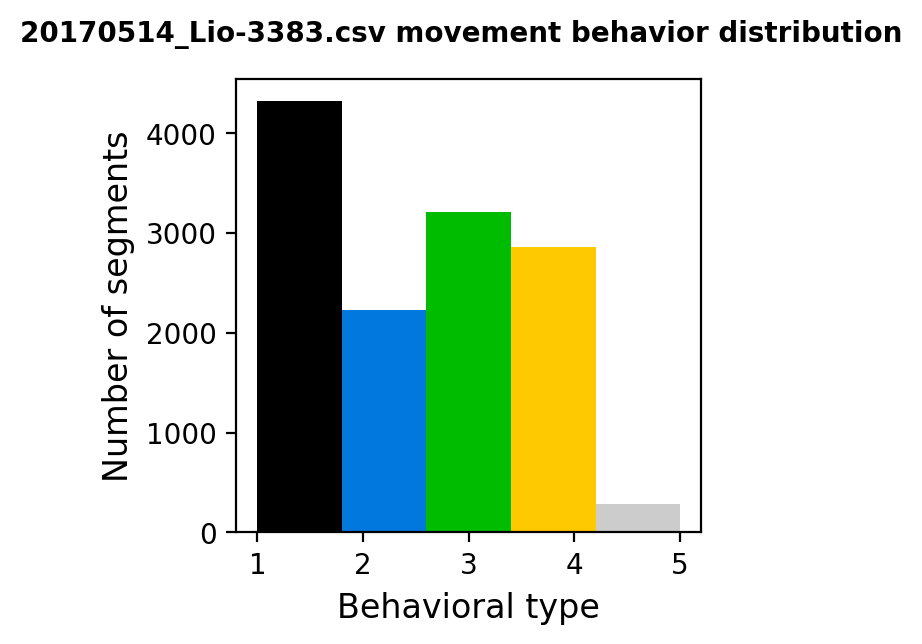

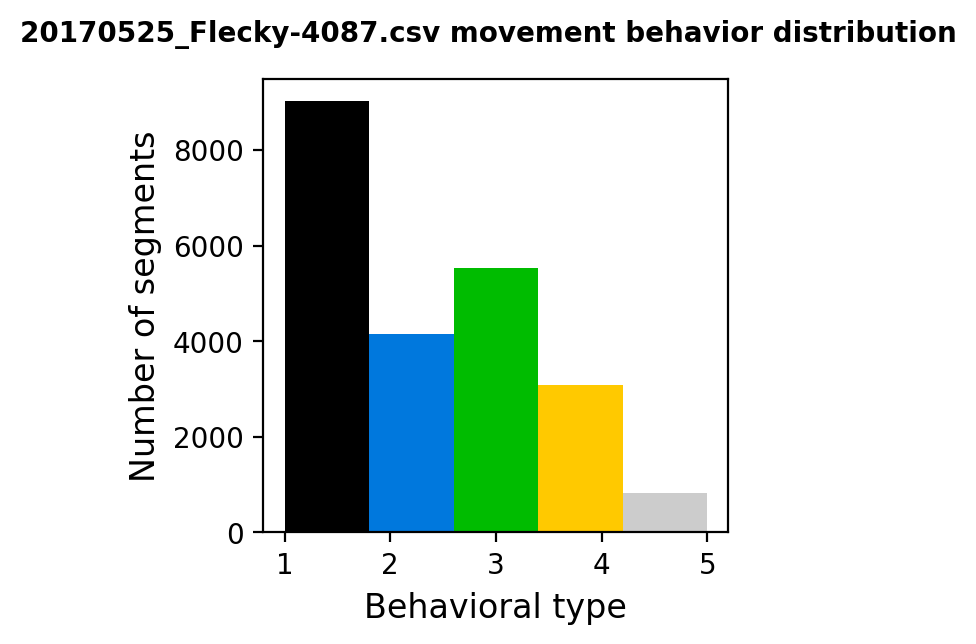

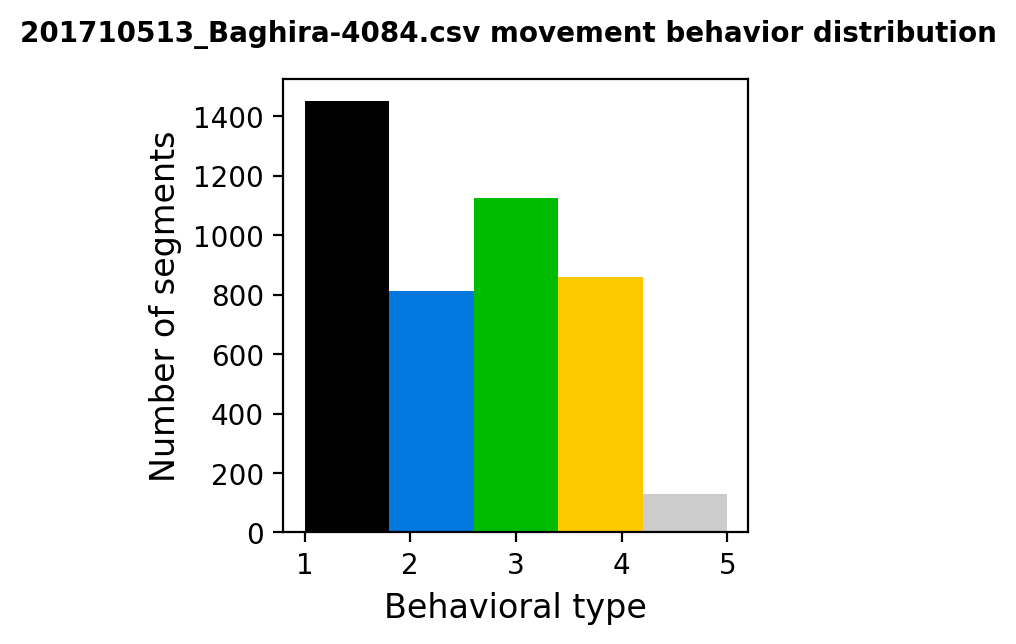

In [20]:
environment = all_cats
for cat_indx in range(len(environment)):
    single_cat = environment_df[environment_df['file'] == environment[cat_indx]]
    fig = plt.figure(figsize=(3, 3), dpi=100)
    fig.suptitle((np.asmatrix(single_cat['file'])[0,0] + ' movement behavior distribution'),
                 fontsize=10, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.set_xlabel('Behavioral type', fontsize=12)
    ax.set_ylabel('Number of segments', fontsize=12)
    n, bins, patches = plt.hist(single_cat['behavioral_label'], bins=number_of_states)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    cm = colormap

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    plt.show()